# check the inference code

In [33]:
import numpy as np

import tools as tl
import CRepDyn_w_STATIC as crep
import CRepDyn_w_DYN as crepw

import matplotlib.pyplot as plt
import networkx as nx
import importlib

from sklearn import metrics
import cv_functions as cvfun
import time_glob as gl

%matplotlib inline

In [34]:
cmap = 'PuBuGn'

In [35]:
def flt(x,d=3):
    return round(x, d)

In [36]:
def calculate_AUC(pred,data0,mask=None):
    # M = expected_Aija(U,V,W)+(eta*B[0,:,:].T)[np.newaxis,:,:]
    # M = expected_Aija(U,V,W)+eta*transpose_ij(B) # conditional expectation (knowing A_ji)
    data = (data0>0).astype('int')
    if mask is None:
        fpr, tpr, thresholds = metrics.roc_curve(data.flatten(), pred.flatten())
    else:
        fpr, tpr, thresholds = metrics.roc_curve(data[mask>0], pred[mask>0])

    return metrics.auc(fpr, tpr)

def expected_Aija(U,V,W):
    if W.ndim==1:
        M=np.einsum('ik,jk->ijk',U,V)
        M=np.einsum('ijk,k->ij',M,W)
    else:    
        M=np.einsum('ik,jq->ijkq',U,V)
        M=np.einsum('ijkq,kq->ij',M,W)
    return M

In [37]:
label = '100_2_5.0_4_0.2_0.2_0'

In [38]:
theta = np.load('../data/input/synthetic/theta_'+label+'.npz',allow_pickle=True)

In [39]:
K = theta['u'].shape[1]

In [40]:
theta['w'].shape

(2, 2)

In [41]:
network = '../data/input/synthetic/syn_'+label+'.dat'

A, B, B_T, data_T_vals = tl.import_data(network,header=0)
nodes = A[0].nodes()
pos = nx.spring_layout(A[0]) 
N = len(nodes) 


   source  target  weight_t0  weight_t1  weight_t2  weight_t3  weight_t4
0       0       5          0          0          0          0          1
1       0       9          1          1          1          1          0
2       0      20          1          0          0          0          0
3       1       3          1          1          0          0          0
4       1      21          1          1          1          1          0
../data/input/synthetic/syn_100_2_5.0_4_0.2_0.2_0.dat shape: (477, 7)
number edges: 234
Number of nodes = 100
Number of layers = 5
Number of edges and average degree in each layer:
E[0] = 234 - <k> = 4.68
M[0] = 234 - <k_weighted> = 4.68
Reciprocity (networkX) = 0.026
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.013
Reciprocity (considering the weights of the edges) = 0.026
E[1] = 242 - <k> = 4.84
M[1] = 242 - <k_weighted> = 4.84
Reciprocity (networkX) = 0.091
Reciprocity (intended as the proportion of bi-di

In [42]:
(B[0]>0).sum()

234

### Initializing near ground truth

In [43]:
gl.timer.verbose = False
gl.timer.color = 'green'
gl.timer.print_details = False
gl.timer.print_sub = True
gl.printer.verboseness = False
gl.parallelize = False

In [44]:
T = B.shape[0] - 1 

u, v and w are initialized using the input files:
../data/input/synthetic/theta_100_2_5.0_4_0.2_0.2_0.npz
(100, 2) (2, 2)
Updating realization 0 ... done!
Nreal = 0 - Loglikelihood = -2908.2244578230566 - iterations = 151 - time = 1.73 seconds


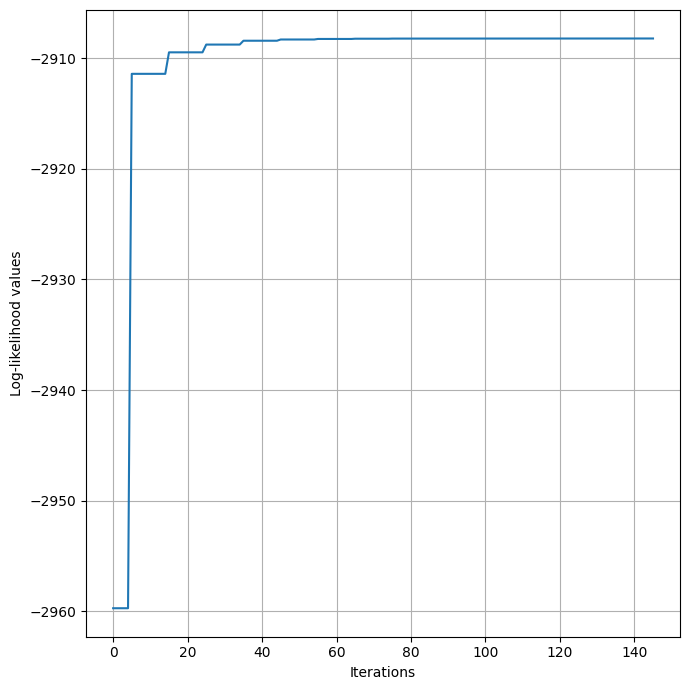

CPU times: user 2.1 s, sys: 255 ms, total: 2.36 s
Wall time: 2.03 s


In [45]:
%%time
importlib.reload(crepw)
algo = 1 # 0: static, 1: w_temp

if algo == 1:
    model = crepw.CRepDyn_w_temp(plot_loglik=True,verbose = 1,N_real=1,beta0=theta['beta'],undirected=False,
                         flag_data_T=1,fix_beta=False,initialization=2,
                             in_parameters='../data/input/synthetic/theta_'+label,
                            max_iter = 700, end_file = label,eta0=0.2,constrained=False,ag=1.1,bg=0.5,fix_eta=False)
elif algo == 0:
    model = crep.CRepDyn(plot_loglik=True,verbose = 1,N_real=1,beta0=0.2,undirected=False,
                         flag_data_T=0,fix_beta=False,initialization=1,
                             in_parameters='../data/input/synthetic/theta_'+label,
                            max_iter = 700, end_file = label,eta0=0.2,constrained=True,ag=1.1,bg=0.5,fix_eta=False)
    
u, v, w,eta,beta, Loglikelihood = model.fit(data=B,T=T, nodes=nodes, K = K)
# out_dict = dict(zip([ 'u', 'v', 'w','eta','beta', 'Loglikelihood'], out))


In [46]:
theta['w']

array([[0.1 , 0.01],
       [0.01, 0.1 ]])

In [47]:
w

array([[[2.99417011e-001, 2.42092379e-073],
        [5.27840905e-075, 2.72761118e-001]],

       [[3.31045595e-001, 2.19070065e-119],
        [1.74837328e-109, 2.25758031e-001]],

       [[3.58963865e-001, 2.62042477e-092],
        [9.80374396e-141, 4.56906569e-001]],

       [[1.95224433e-001, 1.09362474e-096],
        [2.29869866e-110, 3.03143065e-001]],

       [[2.79985465e-001, 2.10815413e-095],
        [2.09405539e-059, 4.40918475e-001]]])

### Eta and beta

In [48]:
print(eta,theta['eta'])
print(beta,theta['beta'])

0.05876206706773662 0.2
0.2169773252428564 0.2


### Cosine Similarity

In [49]:
u, cs_u = cvfun.cosine_similarity(u,theta['u'])
v, cs_v = cvfun.cosine_similarity(v,theta['v'])
cs_u,cs_v


(0.9763491595702473, 0.9614406309005281)

### AUC 

In [50]:
lambda_inf = expected_Aija(u,v,w[0])
M_inf = lambda_inf + eta * crep.transpose_tensor(B)
# M_inf = crep.transpose_tensor(B)
for l in range(model.T+1):
    print(l,flt(cvfun.calculate_AUC(M_inf[l],B[l].astype('int'))))

0 0.809
1 0.829
2 0.844
3 0.852
4 0.854


### A vs M

In [51]:
umax=np.argmax(theta['u'],1)#max of each u
nodelist = []
for k in range(K+1):
    nodelist.extend([i for i in range(N) if umax[i]==k])

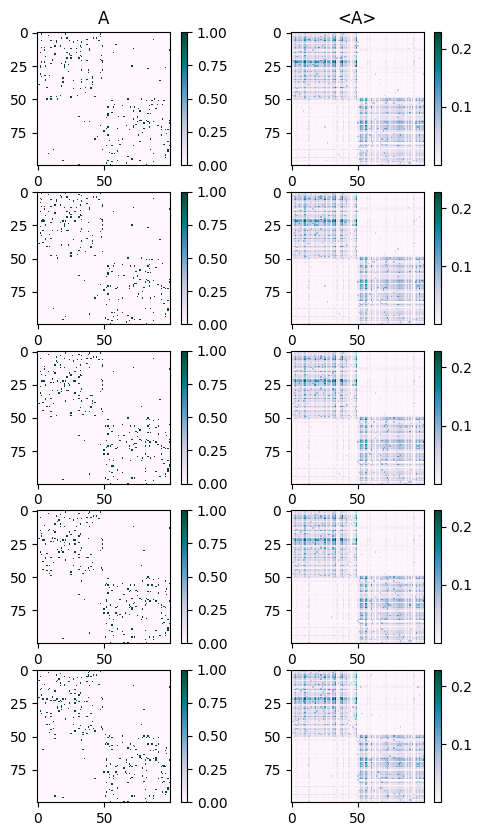

In [52]:
t = 0
plt.figure(figsize=(6,10))
c = 0
for t in range(T+1):
    plt.subplot(T+1, 2, c+1)
    plt.imshow(B[t][nodelist][:,nodelist], cmap=cmap, interpolation='nearest')
    plt.colorbar(fraction=0.046)
    if c == 0:plt.title('A')
    plt.subplot(T+1, 2, c+2)
    plt.imshow(M_inf[t][nodelist][:,nodelist], cmap=cmap, interpolation='nearest')
    plt.colorbar(fraction=0.046)
    if c == 0:plt.title('<A>')
    c += 2
plt.show()

### W

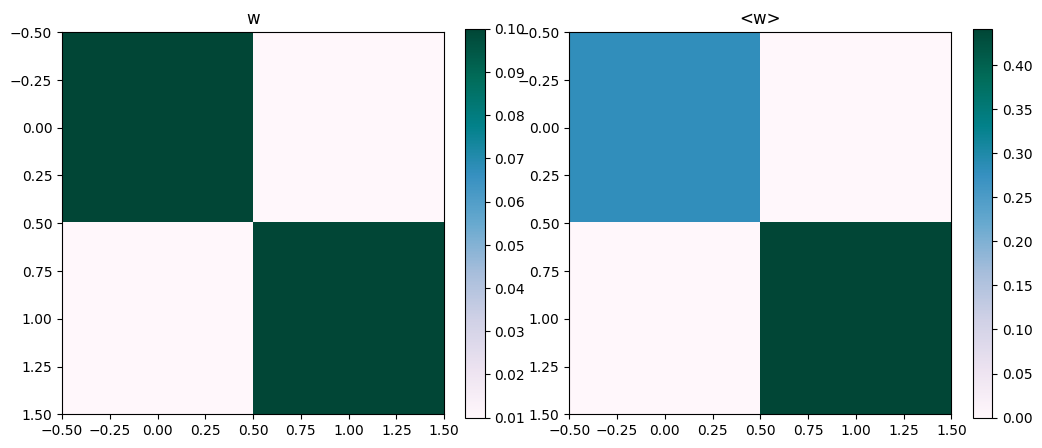

In [53]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(theta['w'], cmap=cmap, interpolation='nearest')
plt.colorbar(fraction=0.046)
plt.title('w')
plt.subplot(1, 2, 2)
if algo == 0:
    plt.imshow(w, cmap=cmap, interpolation='nearest')
else: 
    plt.imshow(w[-1], cmap=cmap, interpolation='nearest')
plt.colorbar(fraction=0.046)
plt.title('<w>')
plt.show()

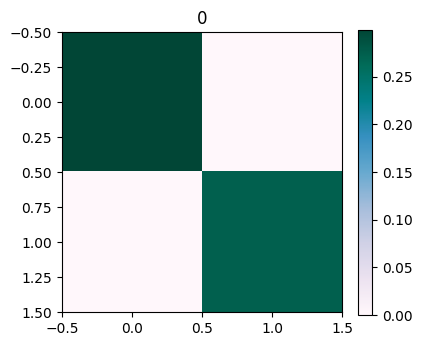

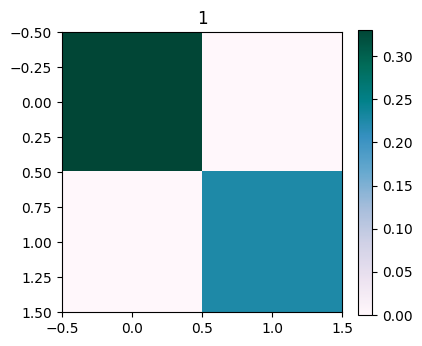

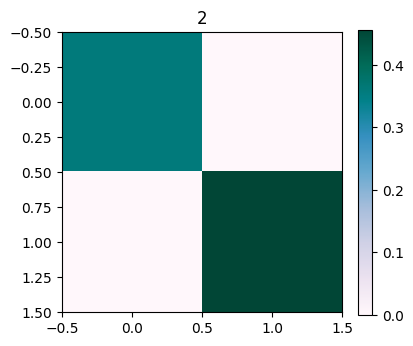

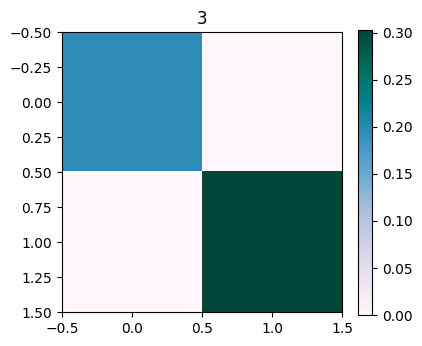

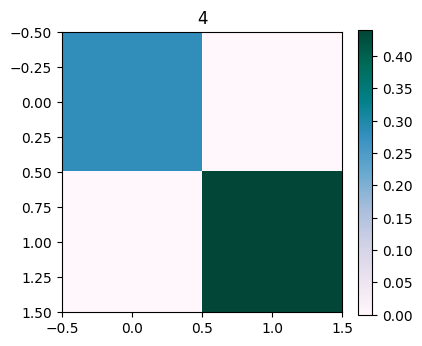

In [54]:
if algo == 0: 
    plt.figure(figsize=(4,4))
    plt.imshow(w, cmap=cmap, interpolation='nearest')
    plt.colorbar(fraction=0.046) 
else:
    for t in range(w.shape[0]): 
        plt.figure(figsize=(4,4))
        plt.imshow(w[t], cmap=cmap, interpolation='nearest')
        plt.colorbar(fraction=0.046)
        plt.title(t)